MLflow is an open-source library for managing the end-to-end machine learning lifecycle. It provides tools for tracking experiments, packaging machine learning models, and deploying models to production. MLflow is particularly useful for XGBoost because it allows users to track and compare the performance of different XGBoost models and quickly deploy the best-performing model to production.

One of the key features of MLflow is its experiment-tracking capability. This allows users to log various metrics, such as model accuracy or training time, and compare the results of different experiments. This can be useful for identifying the most effective hyperparameters for an XGBoost model and choosing the best-performing model.

In addition to these features, MLflow is also library-agnostic, meaning that it can be used with any machine learning library and in any programming language since all functions are accessible through a REST API and CLI. It also offers four primary components: MLflow Tracking, MLflow Projects, MLflow Models, and MLflow Model Registry. These components provide a comprehensive set of tools for managing the entire machine learning lifecycle.

There are several examples of MLflow usage available on GitHub. For instance, the `mlflow/recipes-examples` repository contains example projects for the MLflow Recipes (previously known as MLflow Pipelines) ¹. Another repository, `amesar/mlflow-examples`, provides basic and advanced MLflow examples for many machine learning flavors ². These repositories provide a good starting point for learning how to use MLflow in practice.

Source: Conversation with Bing, 06/05/2023(1) GitHub - mlflow/recipes-examples: Example repo to kickstart integration .... https://github.com/mlflow/recipes-examples Accessed 06/05/2023.
(2) GitHub - amesar/mlflow-examples: Basic and advanced MLflow examples for .... https://github.com/amesar/mlflow-examples Accessed 06/05/2023.
(3) MLflow: A Machine Learning Lifecycle Platform - Github. https://github.com/mlflow/mlflow Accessed 06/05/2023.

In [1]:
import dtreeviz
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier
import urllib
import zipfile
from hyperopt import fmin, tpe, hp, Trials
from EffectiveXGBoost import *

import xgbfir

path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

raw = extract_dataset(path_url, file_name, dataset)

# Create raw X and raw y
kag_X, kag_y = prepX_y(raw, 'Q6')

# Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = (model_selection
                                                    .train_test_split(kag_X, 
                                                                      kag_y, 
                                                                      test_size=.3, 
                                                                      random_state=42, 
                                                                      stratify=kag_y)
                                                   )


# Transform X with pipeline
pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X_train = pline.fit_transform(kag_X_train)
X_test = pline.transform(kag_X_test)

# Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

# Default training
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:62: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 21.1 Installation and Setup

In [2]:
# pip install mlflow

This code snippet demonstrates the use of MLflow to track the hyperparameter tuning process of an XGBoost classifier. The code is organized into several blocks:

1. **Experiment creation and selection**: The first two lines create a new MLflow experiment with the name `'ex3'` and set the artifact location to `'ex2path'`. The second line sets the current experiment to `'ex3'`.

2. **Start run**: The `with mlflow.start_run():` block starts a new MLflow run to track the hyperparameter tuning process.

3. **Hyperparameter tuning**: Within the `with` block, the code defines a list of rounds, where each round contains a dictionary of hyperparameters to be tuned. The `fmin` function from the `hyperopt` library is used to find the best hyperparameters for each round, using the `xhelp.hyperparameter_tuning` function as the objective function. The best hyperparameters for each round are added to the `params` dictionary.

4. **Logging parameters**: After all rounds of hyperparameter tuning are completed, the final set of hyperparameters is logged to MLflow using the `mlflow.log_param` function.

5. **Model training**: An XGBoost classifier is created using the final set of hyperparameters and trained on the training data.

6. **Logging metrics**: Several classification metrics are calculated on the test data and logged to MLflow using the `mlflow.log_metric` function.

7. **Model logging**: Finally, the trained XGBoost model is logged to MLflow using the `mlflow.xgboost.log_model` function.

Overall, this code demonstrates how MLflow can be used to track and organize the process of hyperparameter tuning for a machine learning model.

In [4]:
from feature_engine import encoding, imputation
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn import base, metrics, model_selection, \
pipeline, preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import urllib
import zipfile

In [7]:
ex_id = mlflow.create_experiment(name='ex2', artifact_location='ex2path')
mlflow.set_experiment(experiment_name='ex2')
with mlflow.start_run():
    params = {'random_state': 42}
    rounds = [{'max_depth': hp.quniform('max_depth', 1, 12, 1), # tree
        'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
        {'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}, {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
        {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
    ]
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(
        space, X_train, y_train, X_test, y_test),
                space=params, algo=tpe.suggest, max_evals=10,
                trials=trials,  timeout=60*5 # 5 minutes
    )
params = {**params, **best}
for param, val in params.items():
    mlflow.log_param(param, val)
params['max_depth'] = int(params['max_depth'])
xg = xgb.XGBClassifier(eval_metric='logloss', early_stopping_rounds=50, **params)
xg.fit(X_train, y_train, 
       eval_set=[(X_train, y_train), (X_test, y_test)]
    )
for metric in [metrics.accuracy_score, metrics.precision_score, 
               metrics.recall_score, metrics.f1_score]:
    mlflow.log_metric(metric.__name__, metric(y_test, xg.predict(X_test)))
    
    
model_info = mlflow.xgboost.log_model(xg, artifact_path='model')

          

100%|███████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34trial/s, best loss: -0.7580110497237569]
[0]	validation_0-logloss:0.62144	validation_1-logloss:0.62484
[1]	validation_0-logloss:0.56570	validation_1-logloss:0.56873
[2]	validation_0-logloss:0.54398	validation_1-logloss:0.54441
[3]	validation_0-logloss:0.53169	validation_1-logloss:0.53183
[4]	validation_0-logloss:0.51917	validation_1-logloss:0.52160
[5]	validation_0-logloss:0.51564	validation_1-logloss:0.52093
[6]	validation_0-logloss:0.50826	validation_1-logloss:0.51642
[7]	validation_0-logloss:0.50367	validation_1-logloss:0.51595
[8]	validation_0-logloss:0.49721	validation_1-logloss:0.51415
[9]	validation_0-logloss:0.49319	validation_1-logloss:0.51105
[10]	validation_0-logloss:0.48942	validation_1-logloss:0.50956
[11]	validation_0-logloss:0.48727	validation_1-logloss:0.50998
[12]	validation_0-logloss:0.48228	validation_1-logloss:0.51055
[13]	validation_0-logloss:0.48077	validation_1-logloss:0.51407
[14]	val

2023/05/06 17:23:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\ricky\AppData\Local\Temp\tmp66n9w959\model, flavor: xgboost), fall back to return ['xgboost==1.6.1']. Set logging level to DEBUG to see the full traceback.


In [8]:
 ex_id

'290389368444376236'

In [9]:
model_info.run_id

'3f4e93251dce4da9b4c3b751844009fb'

## 21.2 Inspecting Model Artifacts

You can tell MLFlow to launch a service to inspect the artifacts of training the model.
From the command line, use the following command:
```bash
mlflow ui
```
Then go to the URL localhost:500

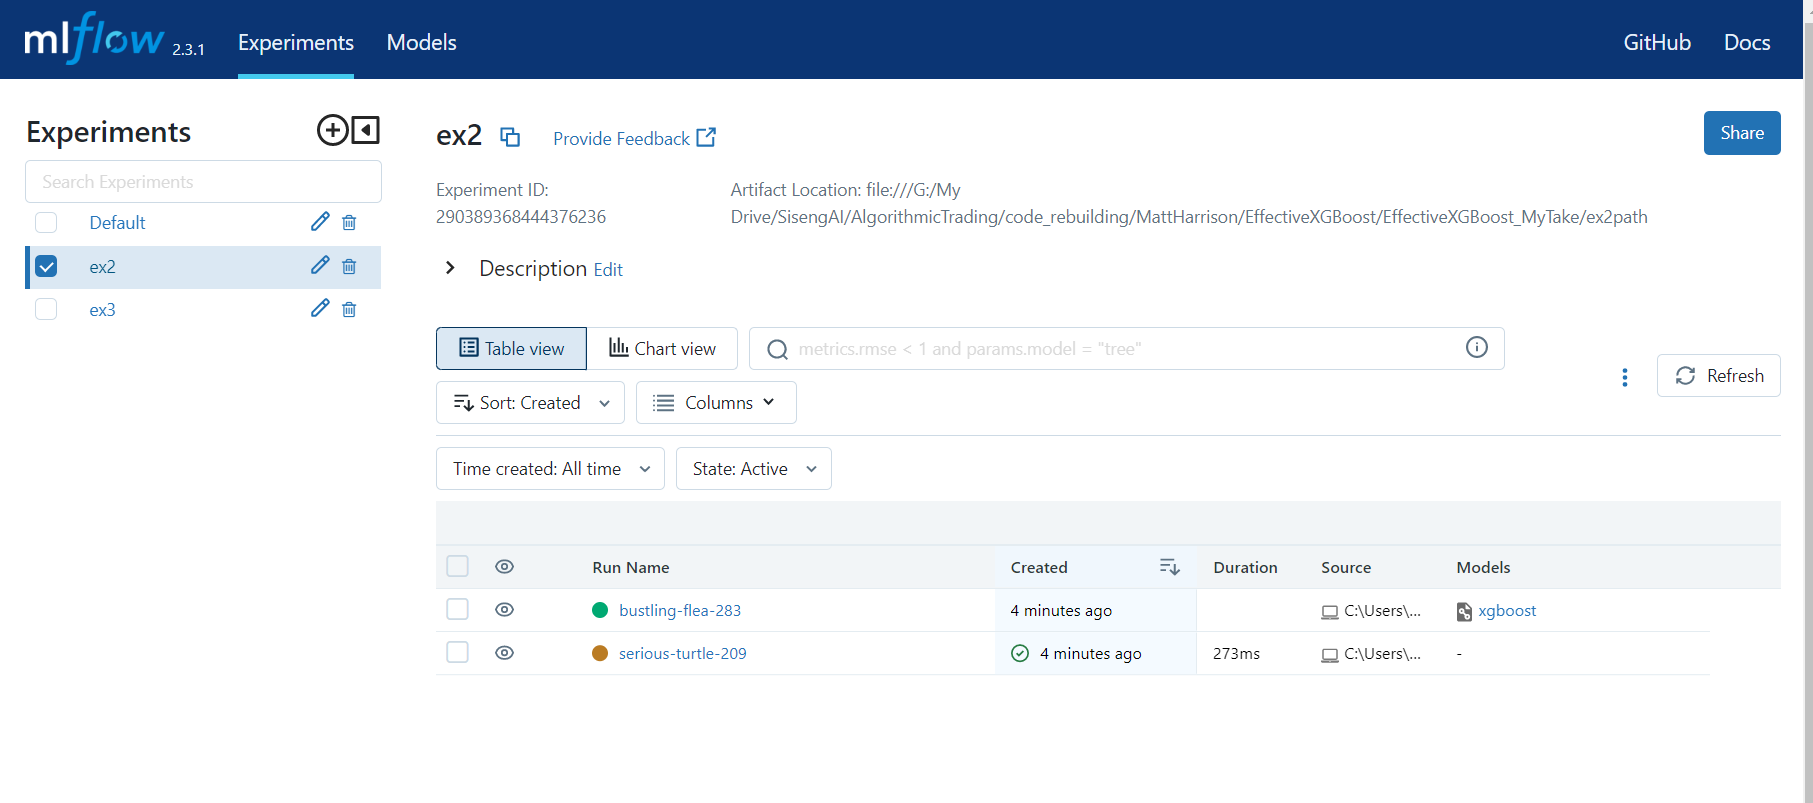

## 21.3 Running A Model From Code

When you click on a finished model, MLFlow will give you the code to make predictions. You
load the model using the load_model function and pass in the run id.

```python
import mlflow
logged_model = 'runs:/ecc05fedb5c942598741816a1c6d76e2/model'
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
```

This code above is available from the website found from launching the command line
service. If you click on the model folder icon, it will show how to make a prediction with
Pandas (like above) or with Spark.
Once you have loaded the model, you can make predictions. Let’s predict the first row of
the test data:
```python
>>> loaded_model.predict(X_test.iloc[[0]])
array([1])
```



## Summary

1. **MLflow library and its main features**: MLflow is an open-source platform for managing the end-to-end machine learning lifecycle. It provides tools for tracking experiments, packaging code into reproducible runs, sharing and deploying models, and managing the model lifecycle in a central model registry. MLflow is designed to work with any machine learning library and language, and can be used in any cloud environment.

2. **Tracking and comparing performance**: MLflow's tracking component allows you to record and query experiments, including parameters, code versions, metrics, and artifacts. This makes it easy to track the performance of different XGBoost models and compare their results. You can use the MLflow UI to visualize and compare the results of different runs.

3. **Packaging and deploying models**: MLflow's model component provides a standard format for packaging machine learning models that can be used across a variety of deployment tools and environments. You can use MLflow to package your XGBoost model into a self-contained format that includes all the dependencies needed to run the model. This makes it easy to share and deploy your model to different environments.

4. **Creating a Docker image**: MLflow provides built-in support for building Docker images for your models. You can use the `mlflow models build-docker` command to create a Docker image that can serve predictions for your model. This makes it easy to deploy your model as a containerized service.

Overall, MLflow provides a comprehensive set of tools for managing the machine learning lifecycle, including tracking experiments, packaging and deploying models, and managing the model lifecycle in a central registry.
